In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematic import ForwardKinematic
from dynamical_system import DynamicalSystem

# DS

In [2]:
# DS parameters
config_dim = 2
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, -0.9])
config_attractor = np.array([0.6, 0.15])

# Embedding parameters
# x = torch.tensor([[-0.5], [0.8], [0.]])
x = np.array([[-0.5], [1.8], [0.]])
mu = np.array([[[0.], [0.5], [0.]], [[0.], [0.51], [0.]]])
sigma = np.array([[[0.0112, 0.0024, 0], [0.0024, 0.0915, 0], [0, 0, 1]], [[0.01, 0.0034, 0], [0.0034, 0.0966, 0.], [0, 0, 1]]])

fk = ForwardKinematic(urdf_file='2_joints_arm.urdf', mu=mu, sigma=sigma)

e = Embedding(dimension=2, x=x[np.newaxis, :, :], initial_mu=mu, initial_sigma=sigma, fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.02)

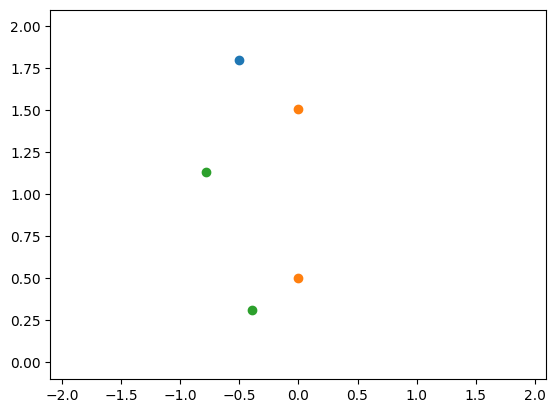

In [3]:
q_start = np.array([0., 0.])
q_end = np.array([0.9, -0.9])
fk(q_start)
plt.figure()
plt.scatter(x[0], x[1])
plt.scatter(fk.absolute_mu[:, 0], fk.absolute_mu[:, 1])
fk(q_end)
plt.scatter(fk.absolute_mu[:, 0], fk.absolute_mu[:, 1])
plt.xlim([-2.1, 2.1])
plt.ylim([-0.1, 2.1])
plt.show()

In [4]:
start = np.array([-0.4, 0.3])
initial_speed = np.array([0.1, -0.1])
q = start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,1000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 1668.2691 Hz


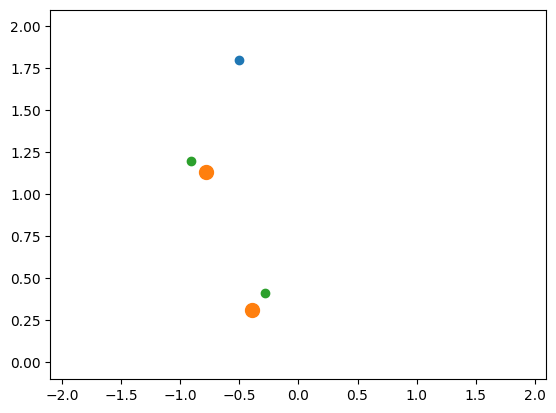

In [5]:
plt.figure()
plt.scatter(x[0], x[1])
fk(q_end)
plt.scatter(fk.absolute_mu[:, 0], fk.absolute_mu[:, 1], s=100)
fk(q)
plt.scatter(fk.absolute_mu[:, 0], fk.absolute_mu[:, 1])
plt.xlim([-2.1, 2.1])
plt.ylim([-0.1, 2.1])
plt.show()

# FK + Embedding

In [6]:
q1 = np.linspace(-2*np.pi, 2*np.pi, 100)
q2 = q1.copy()
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))
print(grid.shape)

(10000, 2)


In [7]:
a = np.zeros((grid.shape[0], 3))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q)
    a[i] = np.array([q[0], q[1], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 43513.19640384993


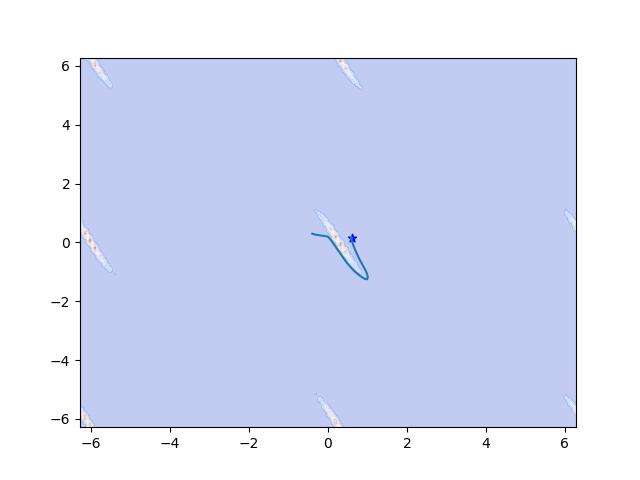

In [8]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(positions)
%matplotlib widget
plt.figure()
plt.contourf(x1, x2,z, cmap=cm.coolwarm, alpha=0.35)
plt.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='b')
plt.plot(ps[:, 0], ps[:, 1])
plt.xlim([x1.min(), x1.max()])
plt.ylim([x2.min(), x2.max()])
plt.show()

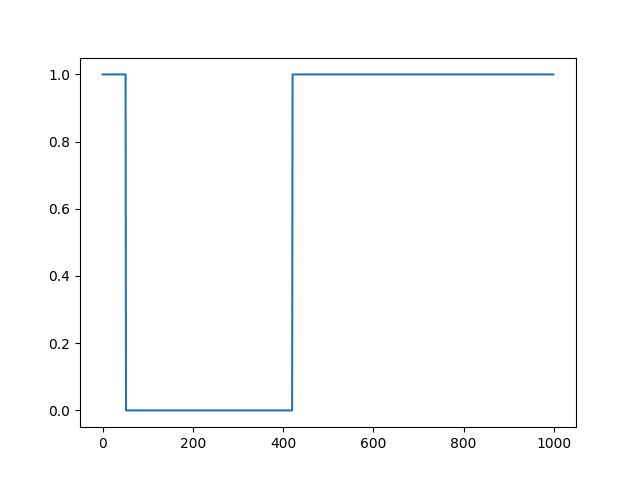

In [9]:
sigma =np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), sigma)
plt.show()

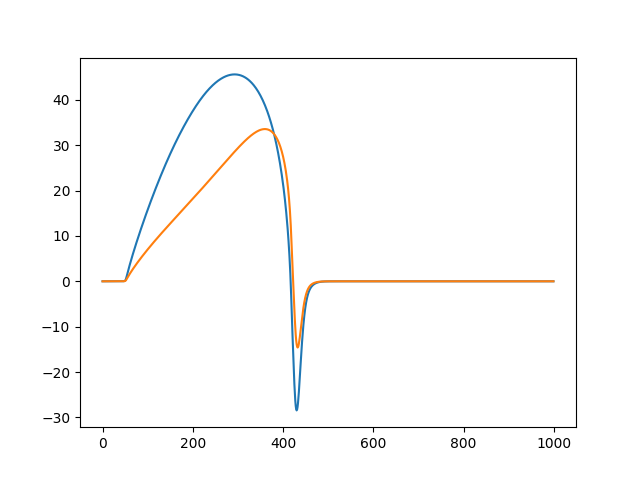

In [10]:
grad =np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 0])
plt.plot(range(len(ds.gradient_logger)), grad[:, :, 1])
plt.show()

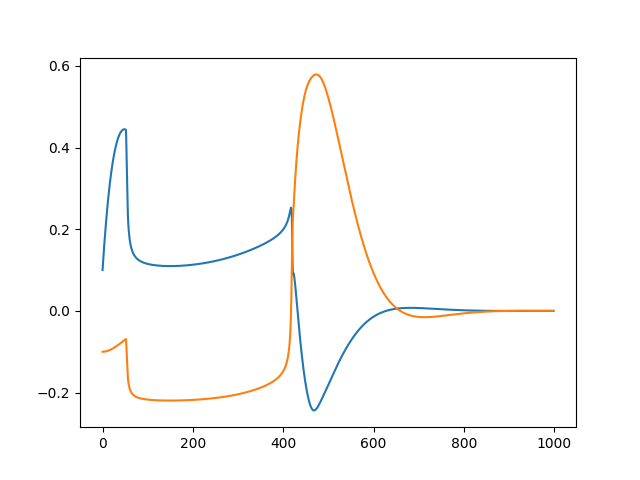

In [11]:
start = 0
end = -1

speed =np.stack(ds.speed_logger)[start :end ]
plt.figure()
plt.plot(range(speed.shape[0]), speed[:, 0])
plt.plot(range(speed.shape[0]), speed[:, 1])
plt.show()

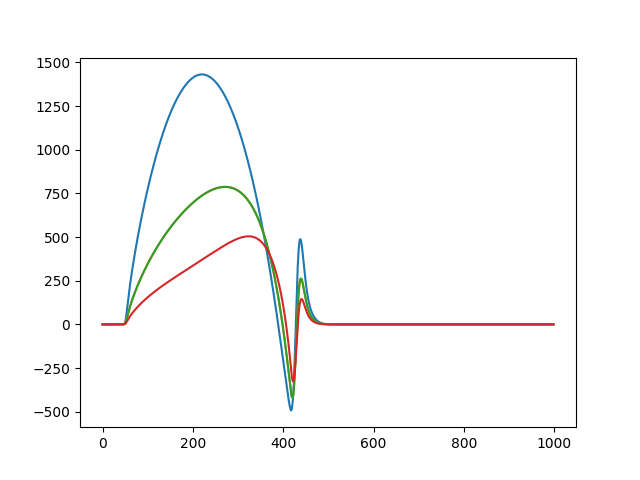

In [12]:
hess =np.stack(ds.hessian_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), hess[:, 0, 0])
plt.plot(range(hess.shape[0]), hess[:, 1, 0])
plt.plot(range(hess.shape[0]), hess[:, 0, 1])
plt.plot(range(hess.shape[0]), hess[:, 1, 1])
# plt.ylim([-820, 420])
plt.show()

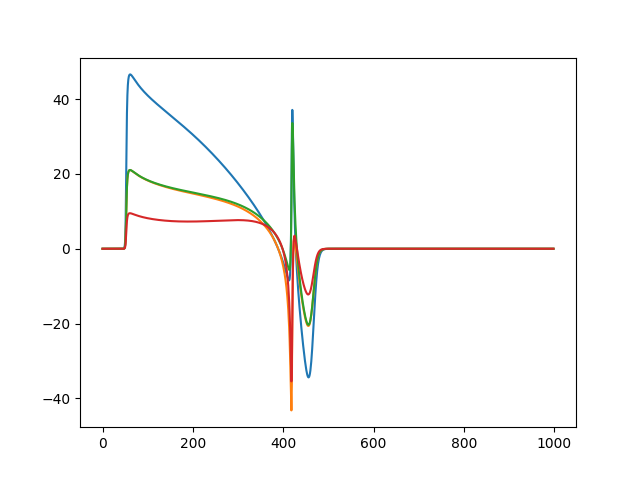

In [13]:
chr =np.stack(ds.christ_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), chr[:, 0, 0, 0])
plt.plot(range(hess.shape[0]), chr[:, 1, 0, 0])
plt.plot(range(hess.shape[0]), chr[:, 0, 1, 0])
plt.plot(range(hess.shape[0]), chr[:, 1, 1, 0])

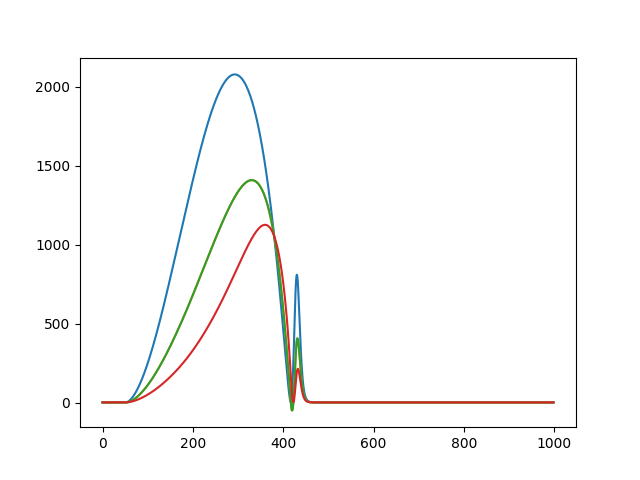

In [14]:
metric =np.stack(ds.metric_logger)[start :end ]
plt.figure()
plt.plot(range(hess.shape[0]), metric[:, 0, 0])
plt.plot(range(hess.shape[0]), metric[:, 0, 1])
plt.plot(range(hess.shape[0]), metric[:, 1, 0])
plt.plot(range(hess.shape[0]), metric[:, 1, 1])

In [15]:
metric.shape

(999, 2, 2)